In [ ]:
# Fill in your name using the given format
your_name = "LAST_NAME, FIRST_NAME"

In [ ]:
# Uncomment for use in Google Colab. Can be ignored if you run notebooks locally.
#!pip install openml --quiet
#!pip install -U scikit-learn --quiet

# Assignment 1
We will study classifiers on the [Kuzushiji dataset](https://www.openml.org/d/41982).
As you can [read in the paper](https://arxiv.org/abs/1812.01718), Kuzushiji is a handwritten 
Japanese script that was used for thousands of years, but most Japanese natives cannot read
it anymore. We'll try to use machine learning to recognize the characters, and translate them to
modern Japanese (Hiragana) characters.

The dataset that we will use contains scanned 28-by-28 pixel images of such handwritten characters.

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [ ]:
# Download Kuzushiji-MNIST data. Takes a while the first time.
# You may receive a warning about data compression but you can ignore that.
data = openml.datasets.get_dataset(41982)
X, y, _, _ = data.get_data(target=data.default_target_attribute);
X = X/265 # Simple scaling 

# These are the names of the modern characters (our 10 classes)
data_classes = {0:"o", 1: "ki", 2: "su", 3: "tsu", 4: "na", 5: "ha", 
                6: "ma", 7: "ya", 8: "re", 9: "wo"}

In [ ]:
# Plotting functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 28x28 images
def plot_examples(images, labels, row_length=5):
    nr_rows = math.floor(len(images) / row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(10, 1.3* nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[math.floor(i/row_length)][i%row_length].set_xlabel(data_classes[int(labels[i])])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())
        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[i].set_xlabel(data_classes[int(labels[i])])
            axes[i].set_xticks(())
            axes[i].set_yticks(())       
    plt.show();

# Plots the coefficients of the given model as 28x28 heatmaps. 
def plot_coefficients(coef, name):
    """ Renders a 28x28 heatmap of the model's trained coefficients.
    Keyword arguments:
    coef -- the model coefficients
    name -- a title for the produced figure
    """
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    fig.suptitle(name)
    ax.imshow(coef.reshape(28,28))
    ax.set_xticks(()), ax.set_yticks(())

### Peeking at the data
If we plot the characters, we see that there is quite some variation. The same
character can be written in a number of different ways.

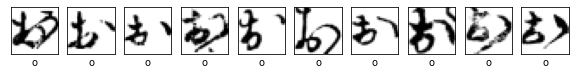

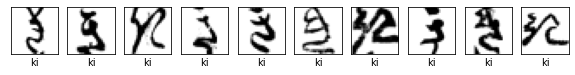

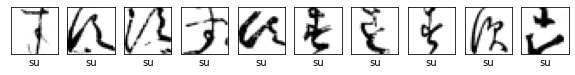

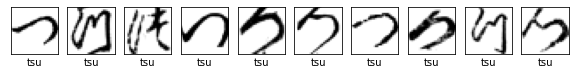

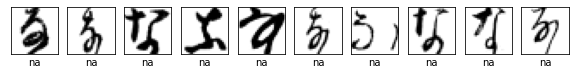

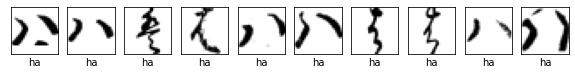

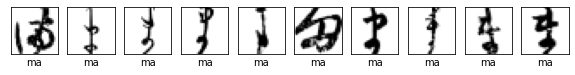

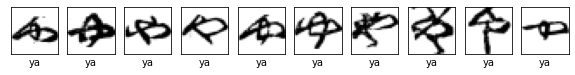

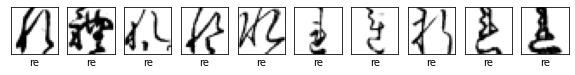

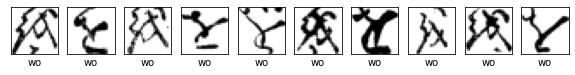

In [ ]:
# Gets indices of examples with the given class
def y_class(c):
    return y[y == str(c)].index.values.tolist()[0:10]

for i in range(10):
    plot_examples(X.to_numpy()[y_class(i)], y.to_numpy()[y_class(i)], row_length=10)

### Question 1.1 (2 points)
Implement a function `evaluate_LR` that evaluates a Logistic Regression model for a given regularization constant (C) and returns the train and test score of a 5-fold cross-validation using the accuracy metric.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Implement
def evaluate_LR(X, y, C):
    """ Evaluate an LR with 5-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    C -- the value for the regularization hyperparameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    cv_log_reg = cross_validate(LogisticRegression(C=C), X, y, return_train_score= True, n_jobs=-1, scoring='accuracy')
    scores = {
    "train": round(np.mean(cv_log_reg['train_score']),2),
    "test": round(np.mean(cv_log_reg['test_score']),2),
    }
    return scores

In [ ]:
#Demonstration
from sklearn.model_selection import train_test_split

Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1, random_state=42)
evaluate_LR(Xs,ys,C=1.0)

{'train': 0.95, 'test': 0.74}

### Question 1.2 (4 points)

Implement a function `plot_curve` that plots the results of `evaluate_LR` on a 10% stratified subsample of the Kuzushiji MNIST dataset vary the C value ranging from 1e-8 to 1e3 (on a log scale, at least 12 values), for the Logistic Regression. You can use the plotting function `plot_live` defined above (carefully read what it does), and add any helper functions you like. Note:  To be clear, you need to pass only 10% of the data to `evaluate_LR`. Using a 10% subsample won't give you optimal performance, but this is meant to make the assignment more doable. If you like you can also use the full dataset.

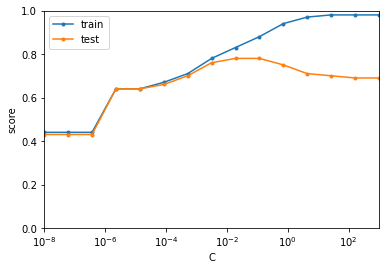

In [ ]:
from sklearn.model_selection import train_test_split

# Implement. Do not change the name or signature of this function.
def plot_curve():
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.1, random_state=42)
    param_range = np.logspace(-8, 3, num=15)
    plot_live(Xs, ys, evaluate_LR, 'C', param_range)

    """
    the similar function can also be implemented as mentioned below.
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.25, random_state=0)
    plot_live(Xs, ys, evaluate_LR, 'C', np.logspace(-8, 3, num=12), scale='log', ylim=(0,1.1))
    """

plot_curve()

### Question 1.3 (2 points)
Interpret the graph. At C=1e-6, is the model underfitting, overfitting, or neither? What about the model trained with C=100?

In [ ]:
q_1_3='A'

C is a hyperparameter for the inverse of regularisation strength. Therefore when C is very small (around 1e-6) then there is too much regularisation and we are underfitting giving us very low scores of just above 0.4 for both the training and test data. 

As we increase the C value the scores improve with a peak for the test data somewhere between 0.01 and 0.1. At this point we fit the data well with an optimum test score of just under 0.8. 

As C gets larger there is less regularisation so the model at C=100 and above is overfitting. Here we have a lower test score of around 0.7 but the training score is around 1.0 signalling overfitting.

Note that this analysis is only for the 10% subsample so results may be different if the whole dataset is used.

### Question 2.1 (4 points)
Use the `plot_coefficients` plotting function to plot a heatmap of the coefficients of three models, one trained with C=10e-6, one with C=0.01, and one with C=10. Only plot the coefficients of the model that separates the character `tsu` from the other characters. You can assume that a one-vs-rest approach is used for multi-class problems, hence the n-th set of coefficients belong to the model that separates the n-th class. You should get three plots in total.

First split the data in a default stratified train-test split. Train the models on the training data and score the accuracy on the test data. Add the C-value and accuracy to the title of the plots. 

Note: You may get convergence warnings. If so, just increase the number of optimization iterations (`max_iter`). Especially models with high C values can take longer to converge (can you guess why?). You can also choose to ignore these warnings since they won't affect the results much.  
Note 2: Recent versions of scikit-learn use a more sophisticated approach than simple one-vs-all, but will still produce one model per class.

C:\Users\ionad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


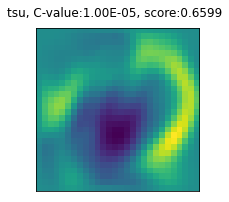

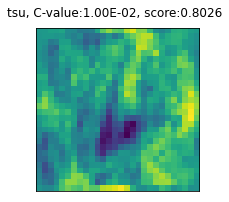

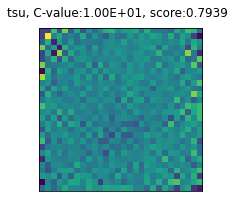

In [ ]:
# Implement. Do not change the name or signature of this function.
def plot_tsu_coefficients(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    param_range = [1e-5, 0.01, 10]
    for c in param_range:
        model = LogisticRegression(C=c, max_iter=1000).fit(X_train, y_train)
        #tsu has key value 3
        plot_coefficients(model.coef_[3], "tsu, C-value:{:.2E}, score:{:.4f}".format(c, model.score(X_test,y_test)))

        """
        can also be written as
        # Simple stratified train-test split
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=0)
        for c in [10e-6, 0.01, 100]:
          model = LogisticRegression(C=c, max_iter=1000).fit(X_train,y_train) # train
          acc = model.score(X_test, y_test) # score
          plot_coefficients(model.coef_[3],"LR (C={}), ACC:{:.4f}".format(c, acc)) # plot for class 3 (tsu)
        """
    
plot_tsu_coefficients(X,y)

#still getting max_iter error so ignoring as already 10 times the default

## Question 2.2 (2 points)
Interpret the results. Which model works best? What is each of the models paying attention to when making predictions? Does that make sense - i.e. did the model learn something useful about the character *tsu*? Compare this to the results
of question 1.2 and 1.3: does that help explain the accuracy results?

In the above images each coefficient is plotted at the location of their corresponding pixel value.

The extreme coefficient values (i.e. very high- bright pixels or very low- dark pixels) will have the highest impact on the final prediction. These are therefore the areas that the model pays the most attention to when making a decision. In our above results we can see the outline of the tsu letter in this shape. For example, in our first two images the model focuses on a sort of arch shape on the right hand side and looks for an absence of pixels in the centre of the image. The model will likely predict that an image is a tsu letter if the sum of these values is high.

With a lower C-value of 1e-5 the tsu-shape is a lot less defined but with more extreme colours. Here there is a large focus on the arch to the top-right of the image and the central absence. Here our model is underfitting explaining the low accuracy score of just over 0.65. 

By increasing the C-value to 0.01 we have less extreme values and can see more focus on certain areas for example at the top and the bottom of the image which in the lower C-value is ignored. There is also an emphasis on a line in the centre which appears in several of the tsu-shapes but is absent from our first image. The central absence is also much smaller than with our lower C-value. This gives us a better accuracy of just over 0.8. 

Finally in the last image with C=10 we are overfitting as the model focuses on very specific pixels relevant to our training data. Here we cannot really see any shapes of the tsu letter, unlike with the two previous images. This overfitting therefore gives us a lower test accuracy than our previous C-value with just below 0.8.

We can therefore conclude that the model with C=0.01 works the best of these three options. The results from explain our results in 1.3 with an optimum value between 0.01 and 0.1, underfitting below this and overfitting above.

## Question 3.1 (4 points)
Let's focus more on the character 'tsu' and the behavior of the model with C=1e-6.

First split the data again in a default stratified train-test split. Train the models on the training data and produce the predictions on the test data.

Next, take the test examples which actually represent 'tsu'. From these, identify the ones which are predicted correctly and which ones are not.

Finally, plot these examples using the `plot_examples` function, together with the predicted class (character). Create two plots: one with 20 examples of 'tsu' characters which are predicted correctly, and a second with 20 examples of 'tsu' characters which are predicted incorrectly by this model.

In [ ]:
def analyze_tsu():
  # Free form coding. Produce the two plots as requested. 
  # Important: the plots must be correct when the notebook is restarted and run from top to bottom.
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
  model = LogisticRegression(C=1e-6).fit(X_train, y_train)
  y_pred = model.predict(X_test)

  #Finding those that represent tsu
  tsu_index = (y_test.astype(int)  == 3)

  #Filtering to these test examples
  y_test = y_test[tsu_index]
  y_pred = y_pred[tsu_index]
  X_test = X_test[tsu_index]

  misclassified_samples =  (y_pred != list(y_test))

  print('Classified correctly')
  images = X_test.iloc[~misclassified_samples].values
  labels = y_pred[~misclassified_samples]
  plot_examples(images[:20], labels[:20])

  print('Classified incorrectly')
  images = X_test.iloc[misclassified_samples].values
  labels = y_pred[misclassified_samples]
  plot_examples(images[:20], labels[:20])

analyze_tsu()

NameError: ignored

## Question 3.2 (2 points)
Interpret the results. Can you explain which kinds of 'tsu' characters are predicted correctly and which ones are not? Compare this with what you observed in question 2.1 and 2.2. What does that tell you about the model?

In [ ]:
#Summary of most common classes for the incorrectly predicted tsu images
elements_count = {}
for element in y_pred[misclassified_samples]:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
for key, value in elements_count.items():
   print(f"{key}: {value}")

#highest counts of incorrectly classified tsu: ki, ha, re

0: 17
5: 86
8: 56
9: 4
4: 27
1: 46
2: 6
6: 13
7: 9


In general the curved 'tsu' character appears to be predicted correctly. There are a lot of examples of correctly predicted images with this form and few in the incorrectly.

However, if there are extra lines beyond the curved form (particularly going into the centre) or the version of the letter is used with two parts then these are not predicted so well. This matches with the results of our most common incorrectly classified predictions for tsu as they are predicted as ki, ha and re. These all have certain forms with lines going through the centre so it is likely that our model sees these pixels and suppresses them as tsu and predicts them as one of these other types.

The above links to our result for 2.1 with C=1e-5 the model focuses on the curved line around the edges. It also suppresses letters here which have pixels coloured in in the centre. Given C=1e-6 here then we can assume that this effect will likely be even more extreme. 

This therefore explains why a lot of these letters have been classified incorrectly.